# Descripción

Clasificación binaria de **Calcificaciones**:
- El tamaño de las imágenes  es de 224x22
- Las etiquetas se generan aquí
- NO se toman en cuenta las imágenes BWC

In [1]:
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2

# CLAHE

In [2]:
# CLAHE STANDAR cliplimit = 40 y grid de 8
clahe_stdr = cv2.createCLAHE()

# Cargamos las  rutas de las imágenes:

Calcificaciones

In [12]:
rutas_train_calc_benign = np.load(r'D:\Guillermo\Pruebas_con_parches_CBIS-DDSM\Rutas_por_etiquetas\nueva_lista_rutas_train_calc_BENIGN_528.npy')

In [13]:
len(rutas_train_calc_benign)

528

In [14]:
rutas_test_calc_benign = np.load(r'D:\Guillermo\Pruebas_con_parches_CBIS-DDSM\Rutas_por_etiquetas\nueva_lista_rutas_test_calc_BENIGN_130.npy')

In [15]:
len(rutas_test_calc_benign)

130

In [16]:
rutas_train_calc_malignant = np.load(r'D:\Guillermo\Pruebas_con_parches_CBIS-DDSM\Rutas_por_etiquetas\nueva_lista_rutas_train_calc_MALIGNANT_544.npy')

In [17]:
len(rutas_train_calc_malignant)

544

In [18]:
rutas_test_calc_malignant = np.load(r'D:\Guillermo\Pruebas_con_parches_CBIS-DDSM\Rutas_por_etiquetas\nueva_lista_rutas_test_calc_MALIGNANT_129.npy')

In [19]:
len(rutas_test_calc_malignant)

129

In [20]:
129+544+130+528

1331

# Generamos las etiquetas (numericas) para ingresarlas al modelo

## Calcificaciones

Malignant = 0, Benign = 1.

In [31]:
etiq_train_calc_malignant = np.zeros(len(rutas_train_calc_malignant), dtype=int)

In [32]:
len(etiq_train_calc_malignant)

544

In [33]:
etiq_test_calc_malignant = np.zeros(len(rutas_test_calc_malignant), dtype=int)

In [34]:
len(etiq_test_calc_malignant)

129

In [35]:
etiq_train_calc_benign = np.ones(len(rutas_train_calc_benign), dtype=int)

In [36]:
len(etiq_train_calc_benign)

528

In [37]:
etiq_test_calc_benign = np.ones(len(rutas_test_calc_benign))

In [38]:
len(etiq_test_calc_benign)

130

# Concatenamos las rutas de las imagenes y etiquetas

In [43]:
rutas_train_calc = np.concatenate((rutas_train_calc_benign,rutas_train_calc_malignant)) #B luego M (1...,0...)

In [44]:
len(rutas_train_calc)

1072

In [45]:
etiq_train_calc = np.concatenate((etiq_train_calc_benign,etiq_train_calc_malignant)) #B luego M (1...,0...)

In [46]:
len(etiq_train_calc)

1072

In [47]:
rutas_test_calc = np.concatenate((rutas_test_calc_benign,rutas_test_calc_malignant)) #B luego M (1...,0...)

In [48]:
len(rutas_test_calc)

259

In [49]:
etiq_test_calc = np.concatenate((etiq_test_calc_benign, etiq_test_calc_malignant)) #B luego M (1...,0...)

In [50]:
len(etiq_test_calc)

259

# Creamos los conjuntos Train, Validación
Usamos  **train_test_split** de sklearn para su reproducibilidad.

In [51]:
X = rutas_train_calc
y = etiq_train_calc

In [52]:
len(X)

1072

In [53]:
len(y)

1072

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42) # stratify=y=labels

In [56]:
len(X_train)

911

In [57]:
len(X_val)

161

# Funciones de TensorFlow

Para realizar operaciones de lectura y resize

In [58]:
import tensorflow as tf
from tensorflow.keras.utils import img_to_array # inst PIL --> ARREGLO NUMPY
from tensorflow.image import resize

Funcion resize con tf:

In [59]:
def resize_dicom_con_clahe(img_dicom,width,height): # Img DICOM readed ---> Tensor([width,heigth,1]), dtype float32 (originalmente son uint 16)
    pxls_img_dicom = img_dicom.pixel_array #Obtenemos los pixeles de las imágenes DICOM
    img_clahe = clahe_stdr.apply(pxls_img_dicom)
    pxls_img_dicom_3D = img_to_array(img_clahe) #Formamos un tensor de la forma (w_DICOM,h_DICOM,1), escala de grises
    img_dicom_resize = resize(pxls_img_dicom_3D,(width,height)) #Se puede plotear con: plt.imshow(img_resize, cmap=plt.cm.bone)
    return img_dicom_resize

# Visualizacion

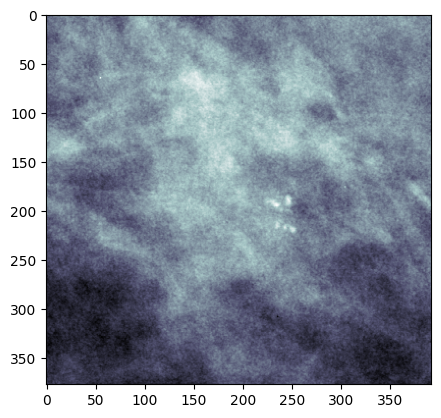

In [60]:
#Tamaño original
plt.imshow(pydicom.dcmread(X_train[100]).pixel_array, cmap=plt.cm.bone) # Img Original

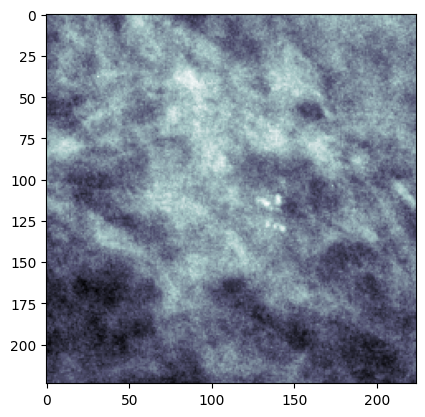

In [61]:
#imagen con resize
plt.imshow(resize_dicom_con_clahe(pydicom.dcmread(X_train[100]),224,224), cmap=plt.cm.bone) #Img con resize

# Obtencion de imagenes como tensores

In [62]:
#Funcion que les hace resize a las imagenes y obtiene los pixeles resultantes den forma de tensores
def genera_tensores_train_test(width,height,lista_de_rutas):
    """
    width a redimensionar
    height a redimensionar
    lista de rutas
    """
    imgs_tensores = []

    for file in list(lista_de_rutas):
        read_img_dicom = pydicom.dcmread(file) #Lectura imgs DICOM
        img_tensor = resize_dicom_con_clahe(read_img_dicom,width,height) #Lammado a la funcion resize_dicom ---> Tensor de "16 bits" con dtype = float32
        imgs_tensores.append(img_tensor) #juntar los tensores

    # Convertir listas a (arrays de NumPy) Tensores
    imagenes = tf.stack(imgs_tensores) #Axis = 0 por default, concatena en vertical(columnas), axis = 1 en horizontal (filas). --->(num_imgs,width,height,1)
    return imagenes # Tensores


## Obtencion de las imágenes como tensores

imgs_train, imgs_val e imgs_test

In [64]:
imgs_train = genera_tensores_train_test(224,224,X_train)

In [65]:
len(imgs_train)

911

In [66]:
imgs_val = genera_tensores_train_test(224,224,X_val)

In [67]:
len(imgs_val)

161

In [68]:
imgs_test = genera_tensores_train_test(224,224,rutas_test_calc)

In [69]:
len(imgs_test)

259

# Preprocesamiento:

In [70]:
# Convertir del rango (0-65535) a (0-255). Recordemos que  2**8 =  (DATOS(2**16)/2**8) neq (65535/65535)*255
train_images_calc = (imgs_train/65535)*255
val_images_calc = (imgs_val/65535)*255
test_images_calc = (imgs_test/65535)*255

In [71]:
#Replicate the only color channel (gray) 3 times, for Pre-trained Nets compatibility (se puede usar tf.TILE)
train_images_calc  = tf.image.grayscale_to_rgb(train_images_calc)
val_images_calc = tf.image.grayscale_to_rgb(val_images_calc)
test_images_calc = tf.image.grayscale_to_rgb(test_images_calc)

In [72]:
train_images_calc.shape

TensorShape([911, 224, 224, 3])

In [73]:
val_images_calc.shape

TensorShape([161, 224, 224, 3])

In [74]:
test_images_calc

<tf.Tensor: shape=(259, 224, 224, 3), dtype=float32, numpy=
array([[[[1.72900040e+02, 1.72900040e+02, 1.72900040e+02],
         [1.88935684e+02, 1.88935684e+02, 1.88935684e+02],
         [2.06776093e+02, 2.06776093e+02, 2.06776093e+02],
         ...,
         [1.99484863e+02, 1.99484863e+02, 1.99484863e+02],
         [1.90770508e+02, 1.90770508e+02, 1.90770508e+02],
         [1.76870728e+02, 1.76870728e+02, 1.76870728e+02]],

        [[1.81529907e+02, 1.81529907e+02, 1.81529907e+02],
         [1.95931213e+02, 1.95931213e+02, 1.95931213e+02],
         [1.95138138e+02, 1.95138138e+02, 1.95138138e+02],
         ...,
         [1.98193909e+02, 1.98193909e+02, 1.98193909e+02],
         [1.82570526e+02, 1.82570526e+02, 1.82570526e+02],
         [1.64333725e+02, 1.64333725e+02, 1.64333725e+02]],

        [[1.78749573e+02, 1.78749573e+02, 1.78749573e+02],
         [1.74814865e+02, 1.74814865e+02, 1.74814865e+02],
         [1.87844055e+02, 1.87844055e+02, 1.87844055e+02],
         ...,
         

# Experimento

In [75]:
from keras import layers
from keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ResNet50, InceptionV3, DenseNet121, MobileNetV2, VGG19, VGG16
#from keras.applications.vgg19 import preprocess_input as  vgg_preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess_input
#from keras.applications.inception_v3 import preprocess_input as inv3_preprocess_input
#from keras.applications.densenet import preprocess_input as dens_preprocess_input
#from keras.applications.mobilenet_v2 import preprocess_input as mob_preprocess_input

Importante al seleccionar la red y el preprocess_input

In [76]:
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input as dens_preprocess_input

# DenseNet121

In [80]:
# Preprocess the test images
test_preprocess = dens_preprocess_input(test_images_calc)

MODELO

In [81]:
def create_dens(fc_size, verbose=False, dropout=None): #fc_size=Número de neuronas finales
  dens_base = DenseNet121(weights='imagenet', #Base convolucional CORRESPONDIENTE
                       include_top=False,
                       input_shape=(224,224, 3)) # Modifica según el tipo de entrada
  dens = models.Sequential()
  dens.add(dens_base)

  dens.add(layers.Flatten())

  #Global AVG Pooling 2D
  #dens.add(layers.GlobalAveragePooling2D())
  if dropout is not None:
    dens.add(layers.Dropout(dropout, seed=42)) # SEMILLA
  dens.add(layers.Dense(fc_size, activation='relu'))
  dens.add(layers.Dense(1, activation='sigmoid')) # TIPO de PROBLEA: Binario o Multietiqueta

  # Freeze the convolutional base
  dens_base.trainable = False

  if verbose:
    dens_base.summary()
    dens.summary()

  return dens

In [82]:
# Create a HARD generator for training images 
train_datagen_HARD_dens = ImageDataGenerator(
    preprocessing_function = dens_preprocess_input, #Preprocess indicado
    #validation_split=0.2, #!!! Separa en validación y entrenamiento !!!
    rotation_range=90,#antes 180
    width_shift_range=0.1,#antes 0.2
    height_shift_range=0.1, # antes 0.2
    shear_range=20, #N Originalmente 10, luego 15
    zoom_range=0.2, #bien
    brightness_range = [0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
)

# Fit the generator with some images
train_datagen_HARD_dens.fit(train_images_calc)
val_datagen_dens = ImageDataGenerator(preprocessing_function = dens_preprocess_input) #Preprocess_input adecuada

# Split train images into actual training and validation
train_generator_HARD_dens = train_datagen_HARD_dens.flow(train_images_calc, y_train, batch_size=64, shuffle=False)#, subset='training')
validation_generator_dens = val_datagen_dens.flow(val_images_calc, y_val, batch_size=64,shuffle=False)#, subset='validation')
#Se comenta subset ya que se ocupan distintos conjuntos de entrenamiento y validación, shuffle=True por default


In [90]:
fc_size = 256
dens_fe_DO_H = create_dens(fc_size = fc_size,dropout=0.5)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('dens_fe_2cl_M-B_best'+f'_{fc_size}_DO_HARD.h5',#NOMBRE
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
dens_fe_DO_H.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) # Cambiar el loss dependiendo del problema

In [91]:
# Train
history_dens_fe_DO_H = dens_fe_DO_H.fit_generator(
        train_generator_HARD_dens, #Generador adecuado
        steps_per_epoch = len(X_train) // 64, #len(train_generator_HARD_dens), #n_train_img // 128, modificar 128 si se modifica el batch size
        epochs=200,
        validation_data=validation_generator_dens,## GENRADOR CORRESP
        validation_steps=len(X_val)//64, #Parametro a usar dependiendo si se dispone de validation data
        callbacks= [checkpoint, earlystopping],
        shuffle=False,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(dens_fe_DO_H, 'dens_fe_2cl_M-B_end'+f'_{fc_size}_DO_HARD.h5') #Modelo correspondiente


C:\Users\uabc_\AppData\Local\Temp\ipykernel_18124\1106565606.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_dens_fe_DO_H = dens_fe_DO_H.fit_generator(


Epoch 1/200
14/14 [==============================] - ETA: 0s - loss: 6.9293 - accuracy: 0.5301
Epoch 1: val_loss improved from inf to 0.64773, saving model to dens_fe_2cl_M-B_best_256_DO_HARD.h5
14/14 [==============================] - 9s 441ms/step - loss: 6.9293 - accuracy: 0.5301 - val_loss: 0.6477 - val_accuracy: 0.5781
Epoch 2/200
14/14 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.6172
Epoch 2: val_loss improved from 0.64773 to 0.62842, saving model to dens_fe_2cl_M-B_best_256_DO_HARD.h5
14/14 [==============================] - 7s 487ms/step - loss: 0.6616 - accuracy: 0.6172 - val_loss: 0.6284 - val_accuracy: 0.5938
Epoch 3/200
14/14 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.6306
Epoch 3: val_loss did not improve from 0.62842
14/14 [==============================] - 5s 315ms/step - loss: 0.6348 - accuracy: 0.6306 - val_loss: 0.7233 - val_accuracy: 0.6484
Epoch 4/200
14/14 [==============================] - ETA: 0s - loss: 0.

In [92]:
#History of accuracy and loss
tra_loss_fe = history_dens_fe_DO_H.history['loss'] # 
tra_acc_fe = history_dens_fe_DO_H.history['accuracy'] #######
val_loss_fe = history_dens_fe_DO_H.history['val_loss'] ########
val_acc_fe = history_dens_fe_DO_H.history['val_accuracy'] #########

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test 
opt_dens_fe_DO_H = models.load_model('dens_fe_2cl_M-B_best'+f'_{fc_size}_DO_HARD.h5') #####Carga el modelo
test_loss_fe, test_acc_fe = dens_fe_DO_H.evaluate(test_preprocess, etiq_test_calc, verbose=False) #######Evalua modelo
opt_test_loss_fe, opt_test_acc_fe = opt_dens_fe_DO_H.evaluate(test_preprocess, etiq_test_calc, verbose=False) ##

print(f"dens Feature Extraction W/ dropout Hard DA {fc_size}\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

dens Feature Extraction W/ dropout Hard DA 256

Epoch [end]: 78
Epoch [opt]: 48
Valid accuracy [end]: 0.6719
Valid accuracy [opt]: 0.7109
Test accuracy [end]:  0.6486
Test accuracy [opt]:  0.6409
Valid loss [end]: 0.6064
Valid loss [opt]: 0.5467
Test loss [end]:  0.6624
Test loss [opt]:  0.6243


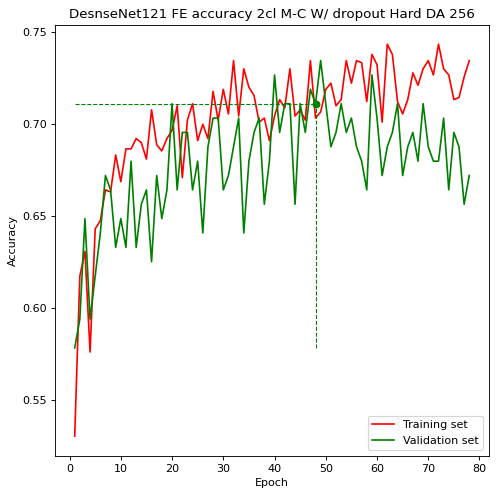

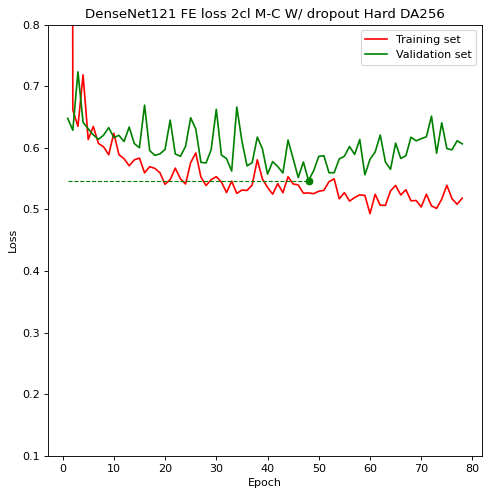

In [94]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title(f'DesnseNet121 FE accuracy 2cl M-C W/ dropout Hard DA {fc_size}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title(f'DenseNet121 FE loss 2cl M-C W/ dropout Hard DA{fc_size}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

dens Feature Extraction W/ dropout Hard DA 256

- Epoch [end]: 78
- Epoch [opt]: 48
- Valid accuracy [end]: 0.6719
- Valid accuracy [opt]: 0.7109
- Test accuracy [end]:  0.6486
- Test accuracy [opt]:  0.6409
- Valid loss [end]: 0.6064
- Valid loss [opt]: 0.5467
- Test loss [end]:  0.6624
- Test loss [opt]:  0.6243

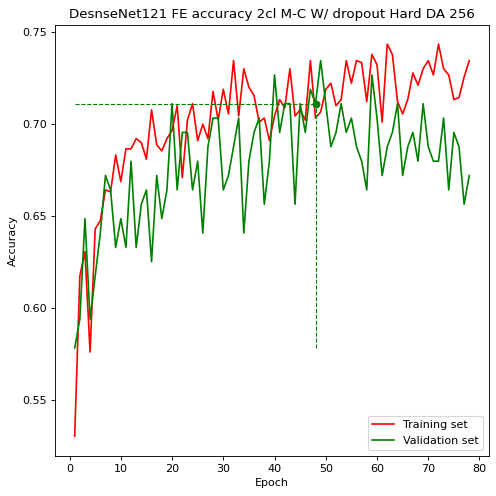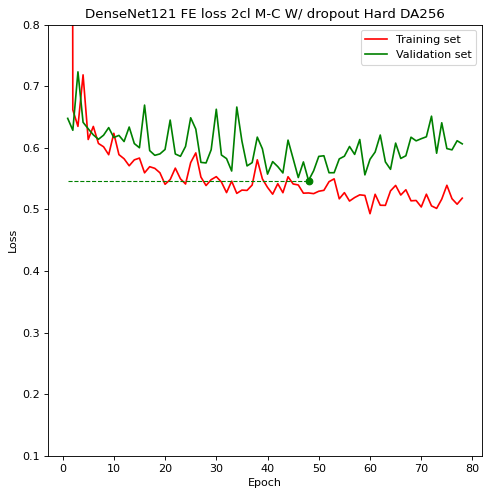

dens Feature Extraction W/ dropout Hard DA 1024

- Epoch [end]: 84
- Epoch [opt]: 54
- Valid accuracy [end]: 0.7109
- Valid accuracy [opt]: 0.7188
- Test accuracy [end]:  0.6757
- Test accuracy [opt]:  0.6100
- Valid loss [end]: 0.6534
- Valid loss [opt]: 0.5774
- Test loss [end]:  0.6456
- Test loss [opt]:  0.6243

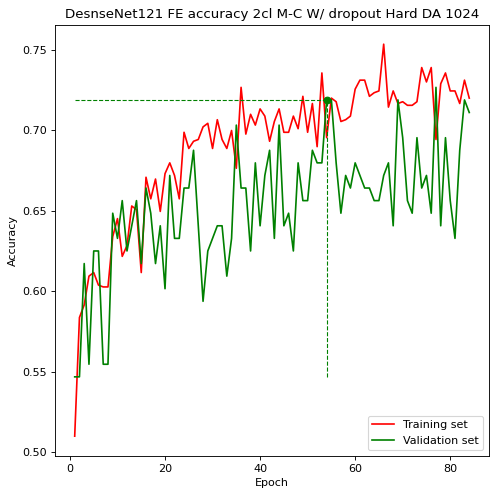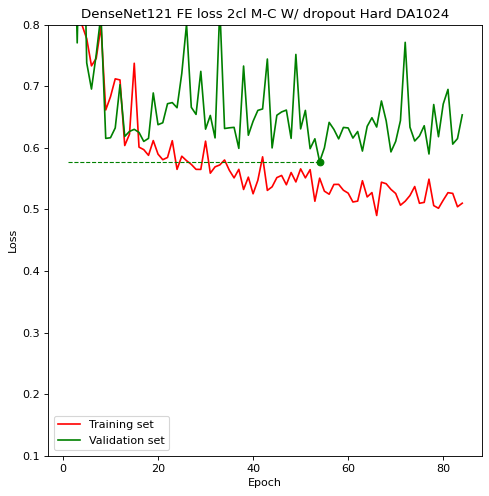

In [89]:
del history_dens_fe_DO_H, dens_fe_DO_H

# Fine Tuning 1 Layer

In [83]:
from tensorflow.keras.optimizers import RMSprop

In [84]:
dens_FT_1layer = models.load_model('dens_fe_2cl_M-B_best_256_DO_HARD.h5') #

fine_tuned_from_1layer = 313

#Fine Tuning: unfreeze the last convolutional layer
for layer in dens_FT_1layer.layers[0].layers[:fine_tuned_from_1layer]:
    layer.trainable = False

for layer in dens_FT_1layer.layers[0].layers[fine_tuned_from_1layer:]:
    layer.trainable = True

# Recompile the model
dens_FT_1layer.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])

dens_FT_1layer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dropout_2 (Dropout)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               12845312  
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 19,883,073
Trainable params: 15,005,697
Non-trainable params: 4,877,376
_________________________________________________________________


In [85]:
# Early stopping (stop training after the validation loss reaches the minimum)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1) 

# Callback for checkpointing
checkpoint = ModelCheckpoint('dens_FT_1layer_2cl_M-B_best_256_DO_HARD.h5', #Nuevo nombre corresp al modelo cargado
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)


In [86]:
# Train
history_FT_1L = dens_FT_1layer.fit_generator(
        train_generator_HARD_dens, #Generador adecuado
        steps_per_epoch = len(X_train)//64, #len(train_generator_HARD_dens), #n_train_img // 128 y GENERADOR CORRESP
        epochs=200,
        validation_data=validation_generator_dens,## GENRADOR CORRESP
        validation_steps = len(X_val)//64,
        callbacks= [checkpoint, early_stop], #Cambia eary stopping arriba
        shuffle=False,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(dens_FT_1layer, 'dens_FT_1layer_2cl_M-B_end_256_DO_HARD.h5') #Modelo correspondiente


C:\Users\uabc_\AppData\Local\Temp\ipykernel_4640\944959721.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_FT_1L = dens_FT_1layer.fit_generator(


Epoch 1/200
14/14 [==============================] - ETA: 0s - loss: 1.3942 - accuracy: 0.6652
Epoch 1: val_loss improved from inf to 0.58688, saving model to dens_FT_1layer_2cl_M-B_best_256_DO_HARD.h5
14/14 [==============================] - 15s 466ms/step - loss: 1.3942 - accuracy: 0.6652 - val_loss: 0.5869 - val_accuracy: 0.6875
Epoch 2/200
14/14 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.6808
Epoch 2: val_loss improved from 0.58688 to 0.58664, saving model to dens_FT_1layer_2cl_M-B_best_256_DO_HARD.h5
14/14 [==============================] - 7s 501ms/step - loss: 0.9070 - accuracy: 0.6808 - val_loss: 0.5866 - val_accuracy: 0.6875
Epoch 3/200
14/14 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.7020
Epoch 3: val_loss did not improve from 0.58664
14/14 [==============================] - 4s 304ms/step - loss: 0.7455 - accuracy: 0.7020 - val_loss: 0.6008 - val_accuracy: 0.6719
Epoch 4/200
14/14 [==============================] - ETA

In [87]:
#History of accuracy and loss
tra_loss_fe = history_FT_1L.history['loss'] # 
tra_acc_fe = history_FT_1L.history['accuracy'] #######
val_loss_fe = history_FT_1L.history['val_loss'] ########
val_acc_fe = history_FT_1L.history['val_accuracy'] #########

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test 
opt_dens_FT = models.load_model('dens_FT_1layer_2cl_M-B_best_256_DO_HARD.h5') #####Carga el modelo
test_loss_fe, test_acc_fe = dens_FT_1layer.evaluate(test_preprocess, etiq_test_calc, verbose=False) #######Evalua modelo
opt_test_loss_fe, opt_test_acc_fe = opt_dens_FT.evaluate(test_preprocess, etiq_test_calc, verbose=False) ##

print("dens Fine Tunig 1 Layer (W/ dropout Hard DA) 256 U\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

dens Fine Tunig 1 Layer (W/ dropout Hard DA) 256 U

Epoch [end]: 32
Epoch [opt]: 2
Valid accuracy [end]: 0.6641
Valid accuracy [opt]: 0.6875
Test accuracy [end]:  0.6409
Test accuracy [opt]:  0.6371
Valid loss [end]: 0.7334
Valid loss [opt]: 0.5866
Test loss [end]:  0.8541
Test loss [opt]:  0.6942


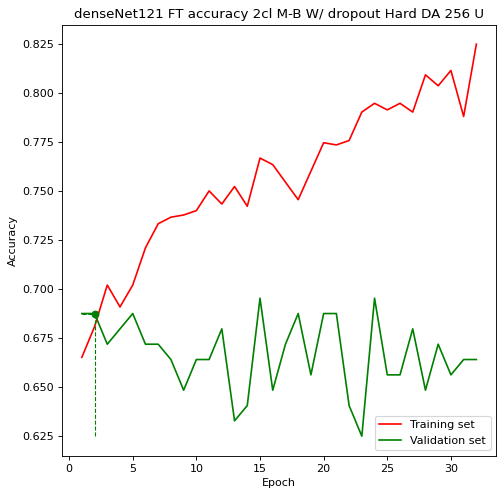

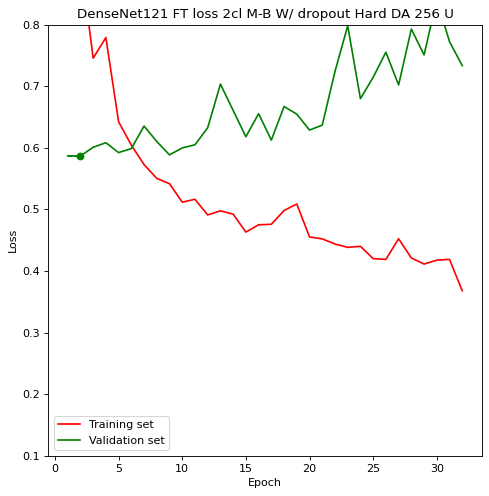

In [88]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('denseNet121 FT accuracy 2cl M-B W/ dropout Hard DA 256 U')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('DenseNet121 FT loss 2cl M-B W/ dropout Hard DA 256 U')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

# Fine Tuning 2 layers

In [90]:
dens_FT_2layer = models.load_model('dens_FT_1layer_2cl_M-B_best_256_DO_HARD.h5') 

fine_tuned_from_2layer = 141

#Fine Tuning: unfreeze the last convolutional layer
for layer in dens_FT_2layer.layers[0].layers[:fine_tuned_from_2layer]:
    layer.trainable = False

for layer in dens_FT_2layer.layers[0].layers[fine_tuned_from_2layer:]:
    layer.trainable = True

# Recompile the model
dens_FT_2layer.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])

#dens_FT_2layer.summary()

In [91]:
# Early stopping (stop training after the validation loss reaches the minimum)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1) 

# Callback for checkpointing
checkpoint = ModelCheckpoint('dens_FT_2layer_2cl_M-B_best_256_DO_HARD.h5', #Nuevo nombre corresp al modelo cargado
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)


In [92]:
# Train
history_FT_2L = dens_FT_2layer.fit_generator(
        train_generator_HARD_dens, #Generador adecuado
        steps_per_epoch = len(X_train)//64, #len(train_generator_HARD_dens), #n_train_img // 128 y GENERADOR CORRESP
        epochs=200,
        validation_data=validation_generator_dens,## GENRADOR CORRESP
        validation_steps = len(X_val)//64,
        callbacks= [checkpoint, early_stop], #Cambia eary stopping arriba
        shuffle=False,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(dens_FT_2layer, 'dens_FT_2layer_2cl_M-B_end_256_DO_HARD.h5') #Modelo correspondiente


C:\Users\uabc_\AppData\Local\Temp\ipykernel_4640\2503300683.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_FT_2L = dens_FT_2layer.fit_generator(


Epoch 1/200
14/14 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.6373
Epoch 1: val_loss improved from inf to 0.59547, saving model to dens_FT_2layer_2cl_M-B_best_256_DO_HARD.h5
14/14 [==============================] - 13s 428ms/step - loss: 1.0037 - accuracy: 0.6373 - val_loss: 0.5955 - val_accuracy: 0.7266
Epoch 2/200
14/14 [==============================] - ETA: 0s - loss: 0.8403 - accuracy: 0.6507
Epoch 2: val_loss did not improve from 0.59547
14/14 [==============================] - 4s 311ms/step - loss: 0.8403 - accuracy: 0.6507 - val_loss: 0.7348 - val_accuracy: 0.6719
Epoch 3/200
14/14 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.6853
Epoch 3: val_loss did not improve from 0.59547
14/14 [==============================] - 4s 312ms/step - loss: 0.6813 - accuracy: 0.6853 - val_loss: 0.7155 - val_accuracy: 0.6953
Epoch 4/200
14/14 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7065
Epoch 4: val_loss did not

In [93]:
#History of accuracy and loss
tra_loss_fe = history_FT_2L.history['loss'] # 
tra_acc_fe = history_FT_2L.history['accuracy'] #######
val_loss_fe = history_FT_2L.history['val_loss'] ########
val_acc_fe = history_FT_2L.history['val_accuracy'] #########

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set 
opt_dens_FT_2L = models.load_model('dens_FT_2layer_2cl_M-B_best_256_DO_HARD.h5') #####Carga el modelo
test_loss_fe, test_acc_fe = dens_FT_2layer.evaluate(test_preprocess, etiq_test_calc, verbose=False) #######Evalua modelo
opt_test_loss_fe, opt_test_acc_fe = opt_dens_FT_2L.evaluate(test_preprocess, etiq_test_calc, verbose=False) ##

print("dens Fine Tunig 2 Layer (W/ dropout Hard DA) 256 U\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

dens Fine Tunig 2 Layer (W/ dropout Hard DA) 256 U

Epoch [end]: 39
Epoch [opt]: 9
Valid accuracy [end]: 0.6484
Valid accuracy [opt]: 0.7344
Test accuracy [end]:  0.6255
Test accuracy [opt]:  0.6293
Valid loss [end]: 1.4618
Valid loss [opt]: 0.5507
Test loss [end]:  1.5689
Test loss [opt]:  0.7508


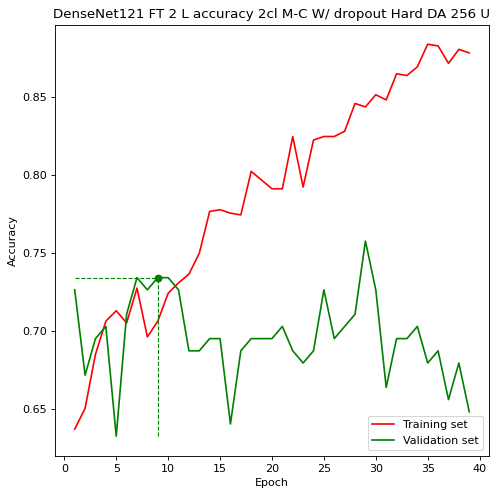

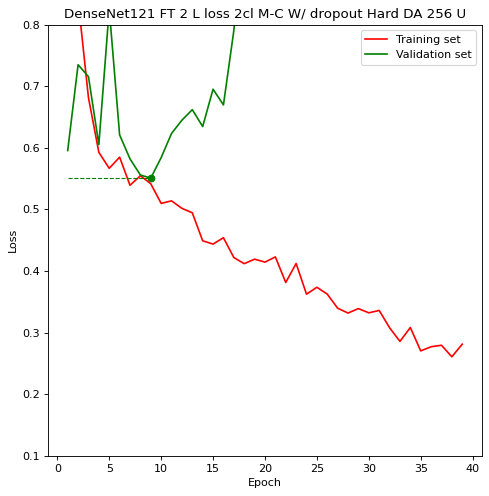

In [94]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('DenseNet121 FT 2 L accuracy 2cl M-C W/ dropout Hard DA 256 U')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('DenseNet121 FT 2 L loss 2cl M-C W/ dropout Hard DA 256 U')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.1,0.8)
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();